This is a notebook training differernt model with only Discount/premium along with historic discount/premium deviations as input

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

In [11]:
def add_mean_dev(df: pd.DataFrame, min_per: int = 100, dev:int=100):
    df[f'DEVIATION_{str(dev)}D'] = df['DISCOUNT/PREMIUM'] - df['DISCOUNT/PREMIUM'].rolling(dev, min_periods=min_per).mean()
    return df

In [39]:
dataframes = []

files = ['Industrivarden_vanlig2_preprocess', 'Latour_preprocess', 'Investor_preprocess']

for file in files:
    df = pd.read_csv(f'data/{file}.csv')
    add_mean_dev(df, min_per=1, dev = 100)
    add_mean_dev(df, min_per=1, dev = 200)
    df["LABEL"] = df["RETURN - OMXS"].apply(lambda x: 1 if x > 0 else 0)
    print(df[['LABEL', 'DISCOUNT/PREMIUM', 'DEVIATION_100D', 'DEVIATION_200D']].head(15))    
    df = df[['DISCOUNT/PREMIUM', 'DEVIATION_100D', 'DEVIATION_200D', 'LABEL', 'DATE']]
    dataframes.append(df)


    LABEL  DISCOUNT/PREMIUM  DEVIATION_100D  DEVIATION_200D
0       1          0.154806        0.000000        0.000000
1       1          0.145181       -0.004813       -0.004813
2       1          0.170886        0.013928        0.013928
3       1          0.157697        0.000554        0.000554
4       1          0.158690        0.001238        0.001238
5       1          0.150062       -0.006159       -0.006159
6       1          0.157635        0.001213        0.001213
7       1          0.156421       -0.000001       -0.000001
8       1          0.165049        0.007668        0.007668
9       1          0.162373        0.004493        0.004493
10      1          0.181102        0.021111        0.021111
11      1          0.171548        0.010594        0.010594
12      1          0.165571        0.004261        0.004261
13      1          0.159763       -0.001436       -0.001436
14      1          0.156342       -0.004533       -0.004533
    LABEL  DISCOUNT/PREMIUM  DEVIATION_1

In [225]:
IV, LATOUR, INVESTOR = dataframes[0], dataframes[1], dataframes[2]

### change company here ###
def aggregate(dataframes):
    combined_df = pd.concat(dataframes, ignore_index=True)
    return combined_df



df = aggregate(dataframes)
    

This approach uses a random test/train split

In [226]:
X = df.drop(columns='LABEL')
Y = df['LABEL']

x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42, test_size=0.20)


print(len(x_train))
print(len(x_test))

4867
1217


This approach uses tha last year as test data and all other datapoints in training

In [227]:
#### ADD CODE HERE

df["DATE"] = pd.to_datetime(df["DATE"])
train_end = pd.Timestamp("2023-12-10")
test_start = pd.Timestamp("2023-12-11")
test_end = pd.Timestamp("2024-12-10")

train_df = df[df["DATE"] <= train_end]
test_df  = df[(df["DATE"] >= test_start) & (df["DATE"] <= test_end)]

x_train = train_df.drop(columns=["LABEL", "DATE"])
y_train = train_df["LABEL"]

x_test  = test_df.drop(columns=["LABEL", "DATE"])
y_test  = test_df["LABEL"]

print(len(x_train))
print(len(x_test))

5325
759


Distribution across labels

In [228]:
length = len(Y)

proportions = Y.value_counts(normalize=True)
print(proportions)

LABEL
1    0.70332
0    0.29668
Name: proportion, dtype: float64


In [229]:
print(x_train.iloc[4])
models = []

DISCOUNT/PREMIUM    0.158690
DEVIATION_100D      0.001238
DEVIATION_200D      0.001238
Name: 4, dtype: float64


CLASSIFICATION MODELS

Logistical regression

In [230]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

logistic_regregression = LogisticRegression(penalty="l2", solver="saga", max_iter=10000, random_state=42)

logistic_regregression.fit(x_train, y_train)

y_pred = logistic_regregression.predict(x_test)

accuracy = accuracy_score(y_pred, y_test)


models.append({'name':'Logitsic Regression', 'model':logistic_regregression})

print(f'The accuracy for Logistic regression is: {accuracy:.4f}')

f1 = f1_score(y_true=y_test, y_pred=y_pred)

print(f"F1 for Logistic regression: {f1:.4f}")

The accuracy for Logistic regression is: 0.6074
F1 for Logistic regression: 0.6667


Visualization

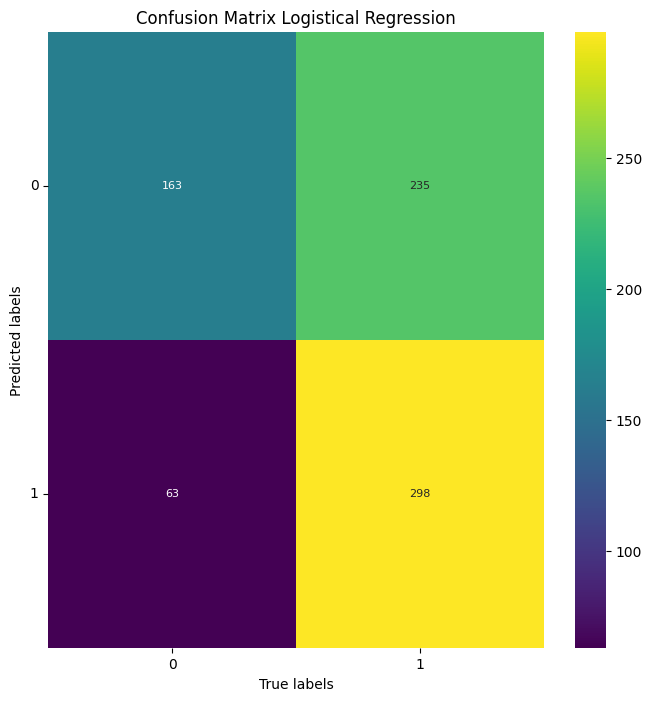

In [231]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


cm = confusion_matrix(y_pred=y_pred, y_true=y_test)

fig, ax = plt.subplots(figsize=(8,8)) 

sns.heatmap(cm, annot=True, fmt='g', ax=ax, annot_kws={'size': 8}, cmap='viridis')

ax.set_xlabel('True labels') 
ax.set_ylabel('Predicted labels')
ax.set_title('Confusion Matrix Logistical Regression') 
plt.yticks(rotation=0)
plt.show()

Decision tree

In [202]:
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier(criterion="gini", splitter="best", random_state=42)

decision_tree.fit(x_train, y_train)

y_pred = decision_tree.predict(x_test)

accuracy = accuracy_score(y_pred, y_test)

models.append({'name':'Decision Trees', 'model':decision_tree})

print(f'The accuracy for the Decision tree classfier {accuracy:.4f}')
f1 = f1_score(y_true=y_test, y_pred=y_pred)

print(f"F1 for Decision tree Classifier: {f1:.4f}")

The accuracy for the Decision tree classfier 0.5520
F1 for Decision tree Classifier: 0.4955


Visualization

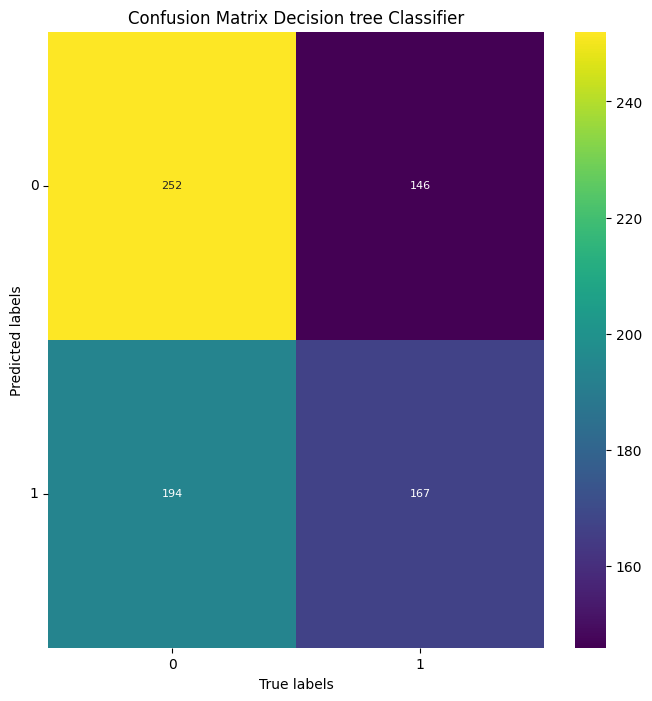

In [203]:
cm = confusion_matrix(y_pred=y_pred, y_true=y_test)

fig, ax = plt.subplots(figsize=(8,8)) 

sns.heatmap(cm, annot=True, fmt='g', ax=ax, annot_kws={'size': 8}, cmap='viridis')

ax.set_xlabel('True labels') 
ax.set_ylabel('Predicted labels')
ax.set_title('Confusion Matrix Decision tree Classifier') 
plt.yticks(rotation=0)
plt.show()

KNN

In [204]:
from sklearn.neighbors import KNeighborsClassifier

nearest_neighbour = KNeighborsClassifier(n_neighbors=5)

nearest_neighbour.fit(x_train, y_train)

y_pred = nearest_neighbour.predict(x_test)

accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)


models.append({'name':'K-nearest neighbor', 'model':nearest_neighbour})

print(f'The accuracy for K nearest neighbour classifier is: {accuracy:.4f}')

f1 = f1_score(y_true=y_test, y_pred=y_pred)

print(f"F1 for K nearest neighbour classifier: {f1:.4f}")

The accuracy for K nearest neighbour classifier is: 0.4888
F1 for K nearest neighbour classifier: 0.4699


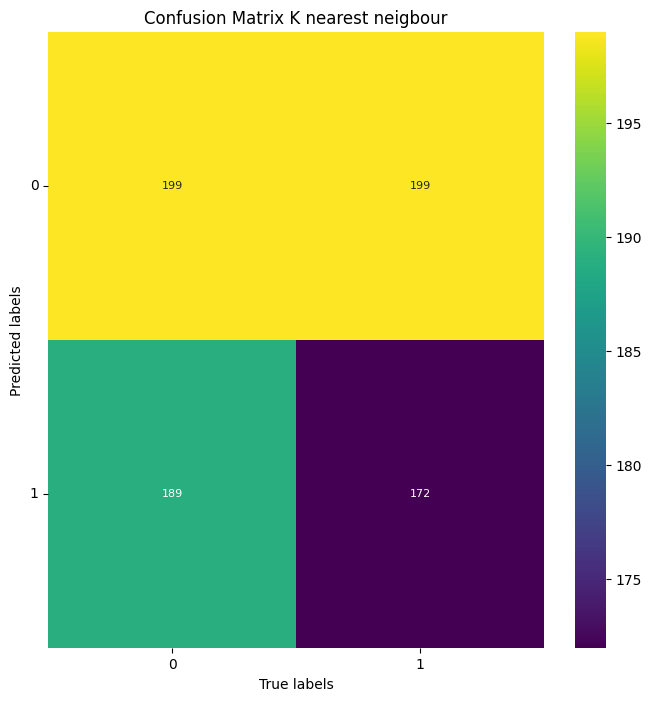

In [205]:
cm = confusion_matrix(y_pred=y_pred, y_true=y_test)

fig, ax = plt.subplots(figsize=(8,8)) 

sns.heatmap(cm, annot=True, fmt='g', ax=ax, annot_kws={'size': 8}, cmap='viridis')

ax.set_xlabel('True labels') 
ax.set_ylabel('Predicted labels')
ax.set_title('Confusion Matrix K nearest neigbour') 
plt.yticks(rotation=0)
plt.show()

Random Forrest

In [206]:
from sklearn.ensemble import RandomForestClassifier


rf= RandomForestClassifier(n_estimators=100, random_state=42)

rf.fit(x_train, y_train)

models.append({'name': 'RandomForestClassifier', 'model': rf})

y_pred = rf.predict(x_test)

accuracy = accuracy_score(y_pred, y_test)
f1 = f1_score(y_true=y_test, y_pred=y_pred)

print(f"Accuracy for the Random Forest Classifier: {accuracy:.4f}")
print(f"F1 for Random Forest Classifier: {f1:.4f}")

Accuracy for the Random Forest Classifier: 0.5415
F1 for Random Forest Classifier: 0.5112


Visualization

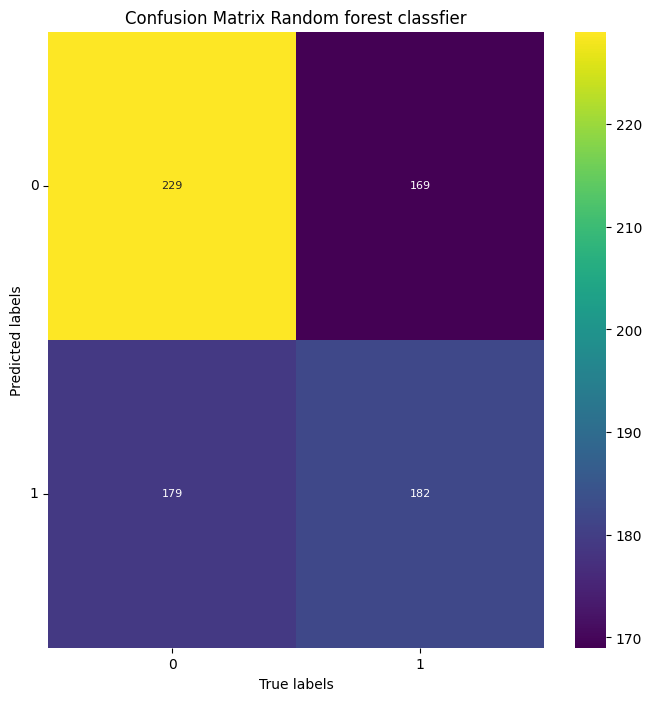

In [207]:

cm = confusion_matrix(y_pred=y_pred, y_true=y_test)

fig, ax = plt.subplots(figsize=(8,8)) 

sns.heatmap(cm, annot=True, fmt='g', ax=ax, annot_kws={'size': 8}, cmap='viridis')

ax.set_xlabel('True labels') 
ax.set_ylabel('Predicted labels')
ax.set_title('Confusion Matrix Random forest classfier') 
plt.yticks(rotation=0)
plt.show()

SVM

In [208]:
from sklearn.svm import SVC

svm = SVC(kernel='linear', C=1.0, gamma='scale', random_state=42)

svm.fit(x_train, y_train)

y_pred = svm.predict(x_test)

accuracy = accuracy_score(y_pred, y_test)

print(f'The accuracy for the SVM classfier {accuracy:.4f}')

f1 = f1_score(y_true=y_test, y_pred=y_pred)


print(f"F1 for SVM Classifier: {f1:.4f}")

models.append ({'name':'SVM', 'model':svm})


The accuracy for the SVM classfier 0.4756
F1 for SVM Classifier: 0.6446


Visualization

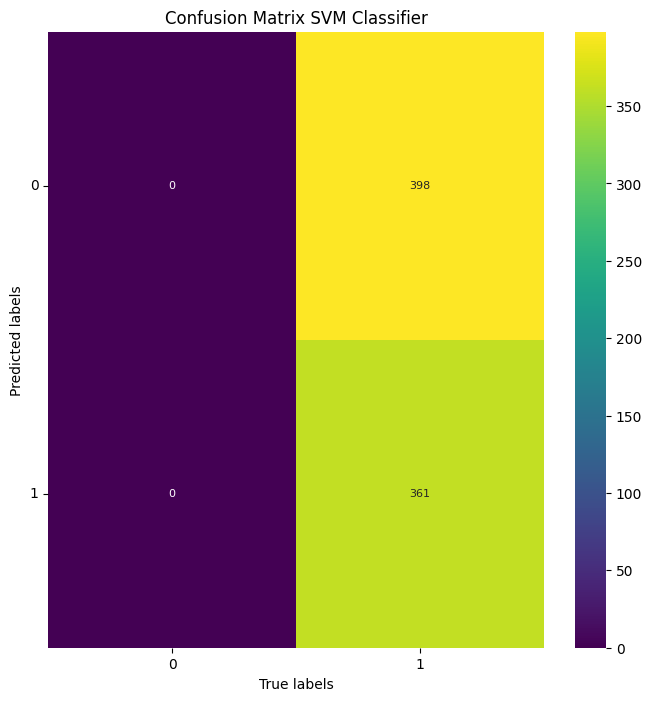

In [209]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_pred=y_pred, y_true=y_test)

fig, ax = plt.subplots(figsize=(8,8)) 

sns.heatmap(cm, annot=True, fmt='g', ax=ax, annot_kws={'size': 8}, cmap='viridis')

ax.set_xlabel('True labels') 
ax.set_ylabel('Predicted labels')
ax.set_title('Confusion Matrix SVM Classifier') 
plt.yticks(rotation=0)
plt.show()